In [5]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 990 µs


In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress, HTML, HBox

from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

time: 3.83 ms


In [8]:
import logging

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

time: 998 µs


In [9]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 1.35 s


In [10]:
import utils # importing from our utils functions

time: 3.86 s


In [11]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 6.24 s


In [12]:
x_train.shape

(36808, 256, 256)

time: 3.46 ms


In [13]:
size = x_train.shape[1]
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 961 µs


# Train Submodel

In [14]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[1.0, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 2.01 ms


In [15]:
datagen.fit(x_train)

time: 14.5 s


In [41]:
with tf.device('/GPU:3'):
    mobilenet = MobileNet(input_shape=(256, 256, 1), weights=None, include_top=False)
    for layer in mobilenet.layers:
        if isinstance(layer, layers.Convolution2D):
            layer.trainable = False
    model = models.Model(input=mobilenet.input, output=layers.Dense(1, activation='sigmoid')(layers.Flatten()(mobilenet.output)))

time: 2.84 s


In [42]:
starting_epoch = 0
train_round = 0
batch_size = 32
epochs_per_eval = 10
epochs_per_save = 30
total_epochs = 90
optimizer = 'adam'
lr = 0.001
train_history = {'loss': [], 'binary_accuracy': [], 'learn_rate': []}
val_per_image_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
val_per_study_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
model_name='4_0_try_mobilenet169'

time: 1.63 ms


In [43]:
def weighted_binary_crossentropy(p1):
    '''
    p1 is the proportion of ones in population
    '''
    w0 = K.variable(p1)
        
    def loss(y_true, y_pred):
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = -(1 - w0) * y_true * K.log(y_pred) - w0 * (1 - y_true) * K.log(1 - y_pred)
        loss = K.sum(loss, -1)
        return loss
    
    return loss

time: 4.81 ms


In [44]:
p1 = y_train.mean()

time: 1.27 ms


In [45]:
# clr = utils.clr.CyclicLR(mode='triangular2')
# opt = optimizers.SGD(nesterov=True)
opt = optimizers.Adam()

time: 10.1 ms


In [46]:
progress = TQDMNotebookCallback(leave_inner=True, leave_outer=True) 

time: 635 µs


INFO:__main__:executing epochs 1-10


INFO:utils.mura_metrics:Accuracy: 0.5342508601814201
INFO:utils.mura_metrics:Kappa: 0.05462608012833945
INFO:utils.mura_metrics:Precision: 0.5195052331113226
INFO:utils.mura_metrics:Recall: 0.3568627450980392


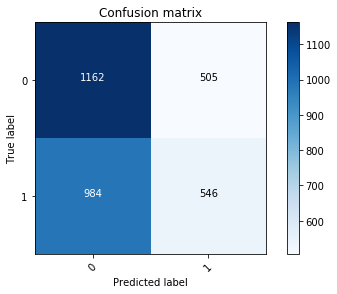

INFO:utils.mura_metrics:Accuracy: 0.5379482902418682
INFO:utils.mura_metrics:Kappa: 0.021034077209447572
INFO:utils.mura_metrics:Precision: 0.47058823529411764
INFO:utils.mura_metrics:Recall: 0.2379182156133829


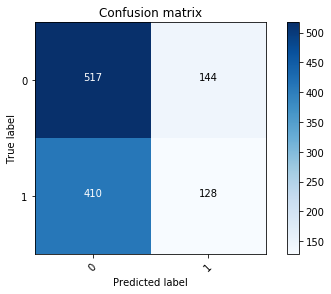

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 11-20


INFO:utils.mura_metrics:Accuracy: 0.5220519236784485
INFO:utils.mura_metrics:Kappa: 0.034723366652558055
INFO:utils.mura_metrics:Precision: 0.5008090614886731
INFO:utils.mura_metrics:Recall: 0.4045751633986928


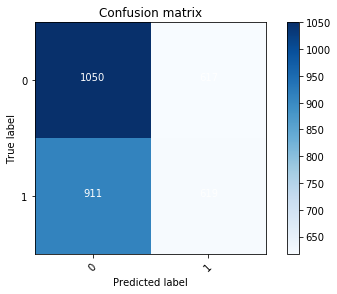

INFO:utils.mura_metrics:Accuracy: 0.5321100917431193
INFO:utils.mura_metrics:Kappa: 0.023707750521428348
INFO:utils.mura_metrics:Precision: 0.4677871148459384
INFO:utils.mura_metrics:Recall: 0.3104089219330855


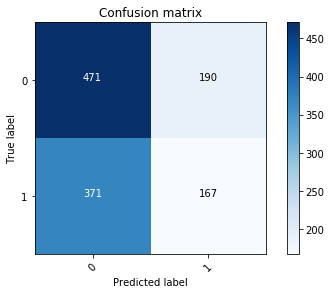

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 21-30


INFO:utils.mura_metrics:Accuracy: 0.5520800750703785
INFO:utils.mura_metrics:Kappa: 0.10048271818594787
INFO:utils.mura_metrics:Precision: 0.5338865836791148
INFO:utils.mura_metrics:Recall: 0.5045751633986928


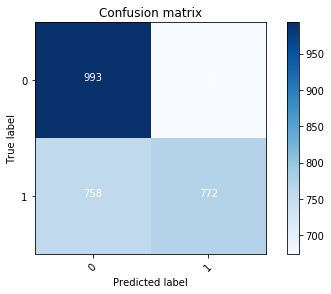

INFO:utils.mura_metrics:Accuracy: 0.5562969140950792
INFO:utils.mura_metrics:Kappa: 0.08929601434584208
INFO:utils.mura_metrics:Precision: 0.5066666666666667
INFO:utils.mura_metrics:Recall: 0.42379182156133827


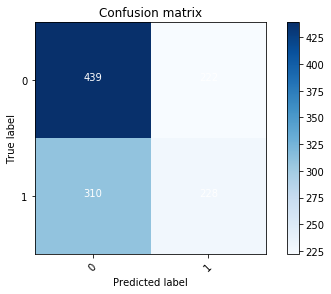

INFO:__main__:Saving Model to trained_models/4_0_try_densenet169_30.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 31-40


INFO:utils.mura_metrics:Accuracy: 0.569283703472005
INFO:utils.mura_metrics:Kappa: 0.12739735503778302
INFO:utils.mura_metrics:Precision: 0.568242640499554
INFO:utils.mura_metrics:Recall: 0.41633986928104577


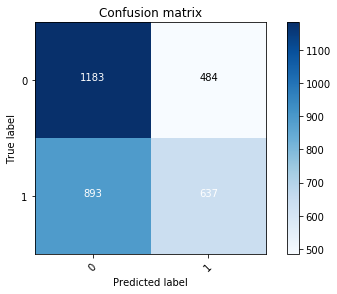

INFO:utils.mura_metrics:Accuracy: 0.5829858215179317
INFO:utils.mura_metrics:Kappa: 0.128152177074547
INFO:utils.mura_metrics:Precision: 0.5549132947976878
INFO:utils.mura_metrics:Recall: 0.35687732342007433


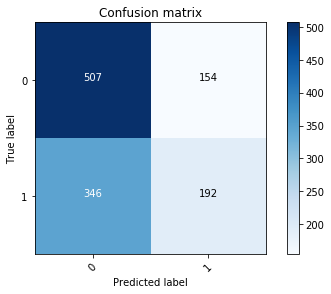

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 41-50


INFO:utils.mura_metrics:Accuracy: 0.5814826399749765
INFO:utils.mura_metrics:Kappa: 0.16692938780327343
INFO:utils.mura_metrics:Precision: 0.5540540540540541
INFO:utils.mura_metrics:Recall: 0.6431372549019608


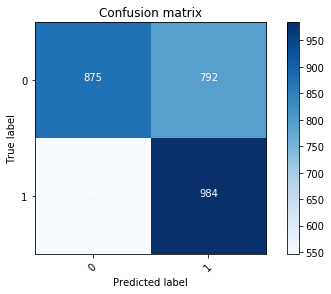

INFO:utils.mura_metrics:Accuracy: 0.5771476230191827
INFO:utils.mura_metrics:Kappa: 0.15306337120605212
INFO:utils.mura_metrics:Precision: 0.5262267343485617
INFO:utils.mura_metrics:Recall: 0.5780669144981413


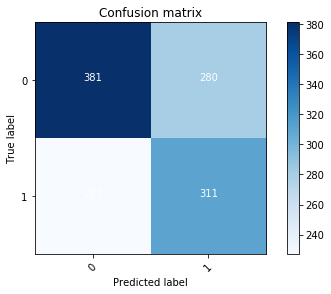

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 51-60


INFO:utils.mura_metrics:Accuracy: 0.5733500156396621
INFO:utils.mura_metrics:Kappa: 0.14494647371215716
INFO:utils.mura_metrics:Precision: 0.5545335085413929
INFO:utils.mura_metrics:Recall: 0.5516339869281046


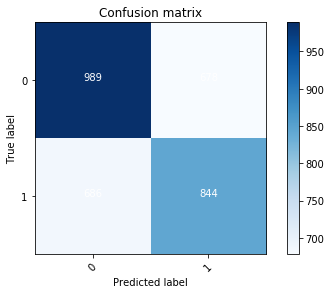

INFO:utils.mura_metrics:Accuracy: 0.5713094245204337
INFO:utils.mura_metrics:Kappa: 0.1271601965810755
INFO:utils.mura_metrics:Precision: 0.5241935483870968
INFO:utils.mura_metrics:Recall: 0.483271375464684


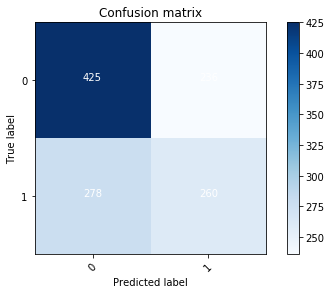

INFO:__main__:Saving Model to trained_models/4_0_try_densenet169_60.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 61-70


INFO:utils.mura_metrics:Accuracy: 0.5864873318736316
INFO:utils.mura_metrics:Kappa: 0.17473350495655793
INFO:utils.mura_metrics:Precision: 0.5619785458879618
INFO:utils.mura_metrics:Recall: 0.6163398692810458


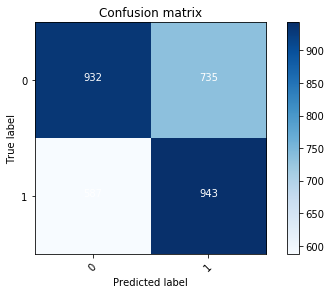

INFO:utils.mura_metrics:Accuracy: 0.5921601334445371
INFO:utils.mura_metrics:Kappa: 0.17692600334389466
INFO:utils.mura_metrics:Precision: 0.5447897623400365
INFO:utils.mura_metrics:Recall: 0.5539033457249071


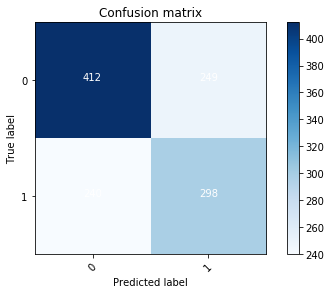

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 71-80


INFO:utils.mura_metrics:Accuracy: 0.603690960275258
INFO:utils.mura_metrics:Kappa: 0.20410679110892788
INFO:utils.mura_metrics:Precision: 0.5910034602076124
INFO:utils.mura_metrics:Recall: 0.5581699346405229


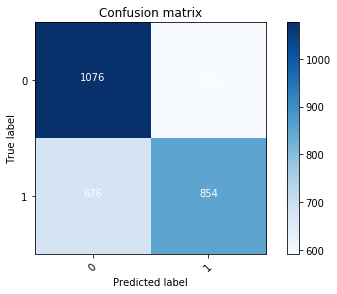

INFO:utils.mura_metrics:Accuracy: 0.6146788990825688
INFO:utils.mura_metrics:Kappa: 0.2094031610286331
INFO:utils.mura_metrics:Precision: 0.584070796460177
INFO:utils.mura_metrics:Recall: 0.49070631970260226


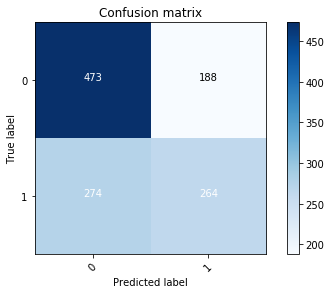

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 81-90


In [ ]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    log.info(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
#     if train_round * epochs_per_eval + 1 + starting_epoch >= 10:
#         if np.mean(train_history['loss'][-10:-5]) < np.mean(train_history['loss'][-5:]): # if no improvements in 5 epochs
#             if optimizer == 'adam':
#                 log.info(f'switching to SGD with lr={lr}')
#                 optimizer = 'sgd'
#             else:
#                 log.info(f'reducing SGD learn rate from {lr} to {lr * 0.8}')
#                 lr = lr * 0.8
#             opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#         else:
#             if optimizer == 'adam':
#                 opt = optimizers.Adam(lr=lr)
#             else:
#                 opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#     else:
#         opt = optimizers.Adam(lr=lr)

    model.compile(
        loss=weighted_binary_crossentropy(p1),
        optimizer=opt,
        metrics=[metrics.binary_accuracy])
    
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch =  int(np.round(len(x_train) / batch_size)), 
                           epochs=epochs_per_eval, verbose=0,
                           callbacks=[progress])
                           # callbacks=[clr, TQDMNotebookCallback()])
    
    # train_history['learn_rate'].extend(clr.history['lr'])
    train_history['loss'].extend(model.history.history['loss'])
    train_history['binary_accuracy'].extend(model.history.history['binary_accuracy'])
    
    y_valid_hat = model.predict(x_test)
    true_label = np.round(y_test)
    pred_label = np.round(y_valid_hat)
    evaluate = utils.MURAMetrics(true_label, pred_label)
    
    per_image_metrics = evaluate.report_by_image()
    for key in per_image_metrics:
        val_per_image_history[key].append(per_image_metrics[key])
    
    per_study_metrics = evaluate.report_by_study()
    for key in per_image_metrics:
        val_per_study_history[key].append(per_study_metrics[key])
    
    cur_epoch = (train_round + 1) * epochs_per_eval
    if cur_epoch % epochs_per_save == 0:
        log.info(f'Saving Model to trained_models/{model_name}_{cur_epoch + starting_epoch}.h5...')
        model.save(f'./trained_models/{model_name}_{cur_epoch + starting_epoch}.h5')
    
    log.info('Saving evaluation metrics history...')
    with open(f'./trained_models/{model_name}_train_history.pkl', 'wb') as pkl_file:
        pickle.dump(train_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_image_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_study_history, pkl_file)
    
    train_round += 1